In [1]:
import os
import sys
import numpy as np
import sklearn as skl
import time
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

sys.path.append("../../../")
import CalibratedTimeseriesModels

from CalibratedTimeseriesModels.utils import *
from CalibratedTimeseriesModels.models.cgmm import *
from CalibratedTimeseriesModels.models.gmnn import *
from CalibratedTimeseriesModels.models.blr import *
from CalibratedTimeseriesModels.evaluators import ExplicitEvaluator

%load_ext autoreload
%autoreload 2

In [2]:
# load data
X_orig = torch.load("../../../datasets/processed/openEI/X_openei_011_subset_multitask.pt")
Y_orig = torch.load("../../../datasets/processed/openEI/Y_openei_011_subset_multitask.pt")

past_dims = 24
fut_dims = 12

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = electric_train_test_split(X_orig, Y_orig, disp_idx=past_dims+fut_dims)

In [3]:
train_idxs = [*range(past_dims)] #,*range(-6,0,1)]

X_train = X_train_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_train = Y_train_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()
X_test = X_test_orig[1,:,train_idxs].reshape((-1,len(train_idxs))).unsqueeze(-1).float()
Y_test = Y_test_orig[1,:,:fut_dims].reshape((-1,fut_dims)).unsqueeze(-1).float()

X_batches, Y_batches = batch(X_train, Y_train, batch_size = 64)

### Conditional Gaussian

In [4]:
lin_reg = BayesianLinearRegression(1, len(train_idxs), 1, fut_dims)
lin_reg.fit(X_train, Y_train)

In [5]:
dtest0 = lin_reg(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest0,Y_test))

(tensor(0.0929), tensor([0.0498, 0.0657, 0.0794, 0.0899, 0.0971, 0.1012, 0.1048, 0.1061, 0.1065,
        0.1059, 0.1048, 0.1035]), tensor([0.0485, 0.0747, 0.0906, 0.1017, 0.1106, 0.1152, 0.1182, 0.1184, 0.1179,
        0.1152, 0.1127, 0.1101]))
(tensor(0.1498), tensor([0.0755, 0.1013, 0.1221, 0.1387, 0.1517, 0.1611, 0.1681, 0.1721, 0.1751,
        0.1765, 0.1776, 0.1782]), tensor([0.0437, 0.0681, 0.0819, 0.0915, 0.0992, 0.1028, 0.1053, 0.1058, 0.1055,
        0.1033, 0.1014, 0.0992]))
(tensor(0.1543), tensor([0.0055, 0.0099, 0.0150, 0.0197, 0.0238, 0.0269, 0.0289, 0.0300, 0.0308,
        0.0312, 0.0317, 0.0323]), tensor([0.0109, 0.0206, 0.0326, 0.0448, 0.0567, 0.0656, 0.0712, 0.0760, 0.0796,
        0.0815, 0.0831, 0.0846]))
(tensor(0.1991), tensor([0.0094, 0.0167, 0.0246, 0.0320, 0.0386, 0.0438, 0.0474, 0.0499, 0.0517,
        0.0528, 0.0539, 0.0550]), tensor([0.0109, 0.0206, 0.0326, 0.0449, 0.0568, 0.0658, 0.0713, 0.0761, 0.0797,
        0.0815, 0.0831, 0.0847]))
(tensor(-18.9578), t

### Conditional Gaussian Mixture Model

In [6]:
cgmm = ConditionalGMM(1, len(train_idxs), 1, fut_dims, n_components=4, random_state=14)
cgmm.fit(X_train, Y_train)

In [7]:
dtest1 = cgmm(X_test)
for f in [mape, wape, rmse, rwse, nll]:
    print(f(dtest1,Y_test))

(tensor(0.0820), tensor([0.0392, 0.0570, 0.0701, 0.0764, 0.0817, 0.0863, 0.0902, 0.0932, 0.0948,
        0.0963, 0.0985, 0.1001]), tensor([0.0423, 0.0657, 0.0800, 0.0890, 0.0962, 0.1030, 0.1076, 0.1101, 0.1136,
        0.1141, 0.1150, 0.1160]))
(tensor(0.1217), tensor([0.0586, 0.0847, 0.1012, 0.1109, 0.1185, 0.1267, 0.1324, 0.1359, 0.1400,
        0.1438, 0.1499, 0.1572]), tensor([0.0419, 0.0636, 0.0765, 0.0840, 0.0912, 0.0983, 0.1027, 0.1047, 0.1064,
        0.1071, 0.1117, 0.1185]))
(tensor(0.1402), tensor([0.0031, 0.0068, 0.0107, 0.0140, 0.0173, 0.0207, 0.0234, 0.0254, 0.0271,
        0.0280, 0.0292, 0.0303]), tensor([0.0066, 0.0146, 0.0227, 0.0306, 0.0400, 0.0505, 0.0591, 0.0677, 0.0731,
        0.0750, 0.0773, 0.0798]))
(tensor(0.1940), tensor([0.0057, 0.0122, 0.0188, 0.0251, 0.0315, 0.0385, 0.0443, 0.0492, 0.0531,
        0.0552, 0.0579, 0.0599]), tensor([0.0068, 0.0152, 0.0243, 0.0340, 0.0458, 0.0589, 0.0698, 0.0803, 0.0867,
        0.0889, 0.0913, 0.0925]))
(tensor(-22.1205), t

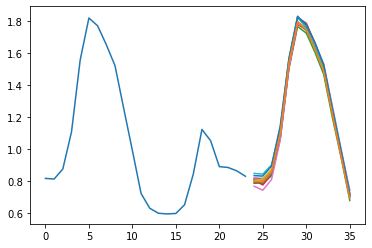

In [10]:
plt.plot(range(24),X_test[0,:,0])
plt.plot(range(24,36), dtest1.sample((10,))[:,0,:].T)
plt.plot(range(24,36),Y_test[0,:]) #orange
plt.show()